In [2]:
import copy

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, figure, show
import numpy as np
import scipy.io as sio
import scipy.signal
from rich import print


---
# VIDEO: Mean-smooth a time series
---


### Create Signal

time = [0.000e+00 1.000e-03 2.000e-03 ... 2.997e+00 2.998e+00 2.999e+00] (Ts = 0.001)

n = 3000

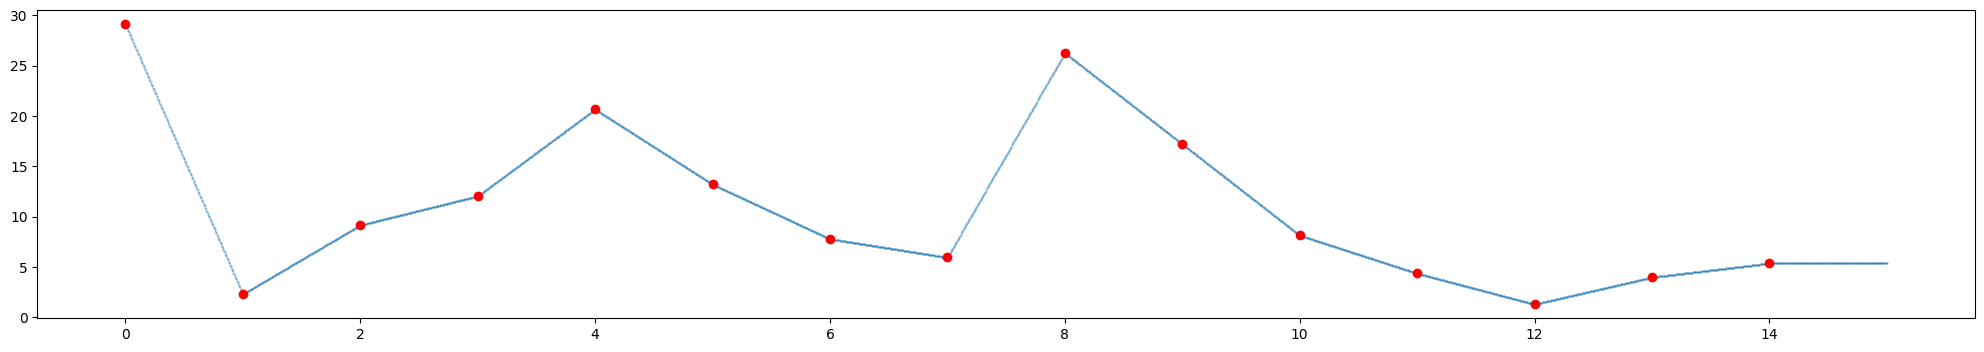

In [3]:
srate = 1000  # Hz
Ts = 1 / srate  # 0.001 sec

time = np.arange(0, 3, Ts)  #  [0.000e+00 1.000e-03 2.000e-03 ... 2.997e+00 2.998e+00 2.999e+00]
n = len(time)  # 3000

print(f"time = {time} (Ts = {Ts})")
print(f"n = {n}")

# amplitude modulator and noise level
p = 15  # poles for random interpolation

# Clean signal
px = np.arange(0, p)  # 15 points from 0 to 14  (x-axis of the interpolation)
py = np.random.rand(p) * 30  # 15 random points from 0 to 30 (y-axis of the interpolation)

# Noisy signal
x = np.linspace(0, p, n)  # 3000 points from 0 to 15

ampl0 = np.interp(x=x, xp=px, fp=py)  # 3000 points interpolated from the 15 points

figure(figsize=(25, 4))
plot(x, ampl0, ".", label="Amplitude", markersize=1, alpha=0.5)
plot(px, py, "ro", label="Poles")
show()

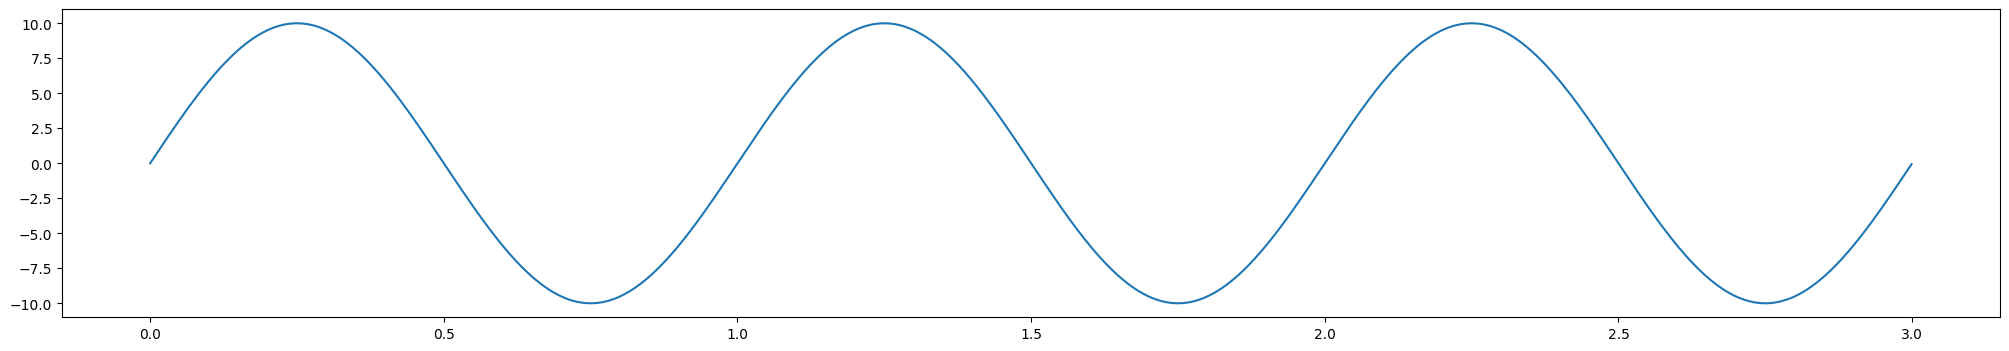

In [4]:
# A senoidal signal
figure(figsize=(25, 4))
ampl = 10 * np.sin(2 * np.pi * 1.0 * time)
plot(time, ampl)
show()

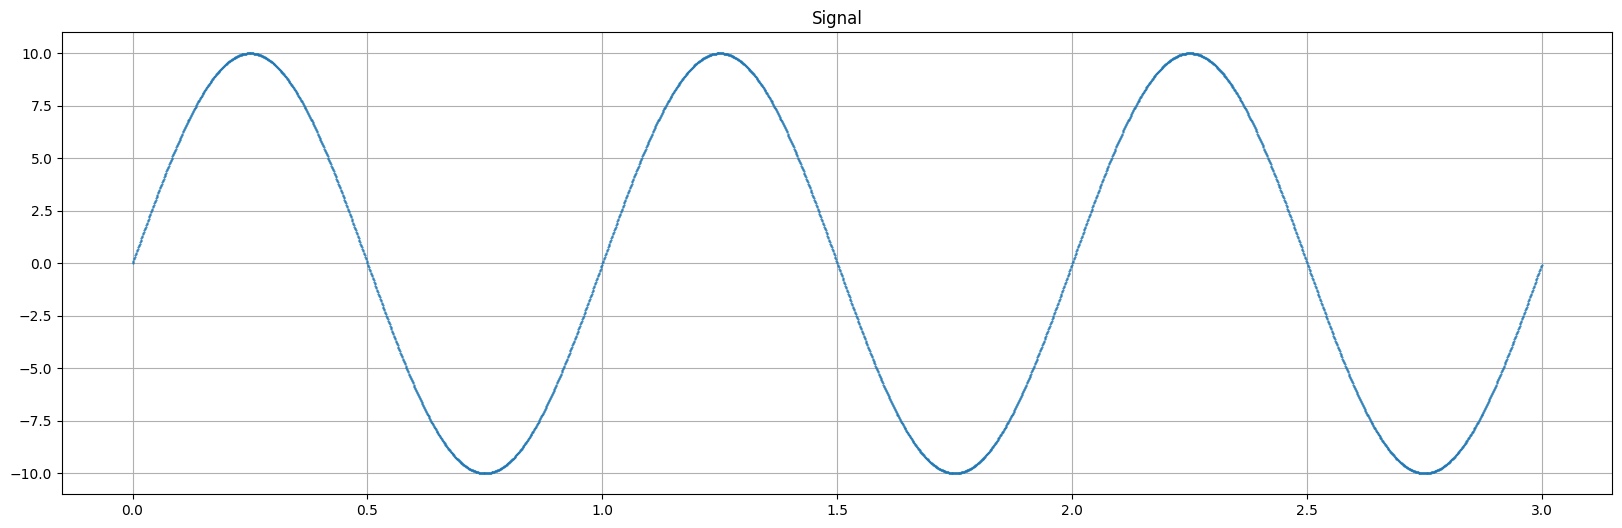

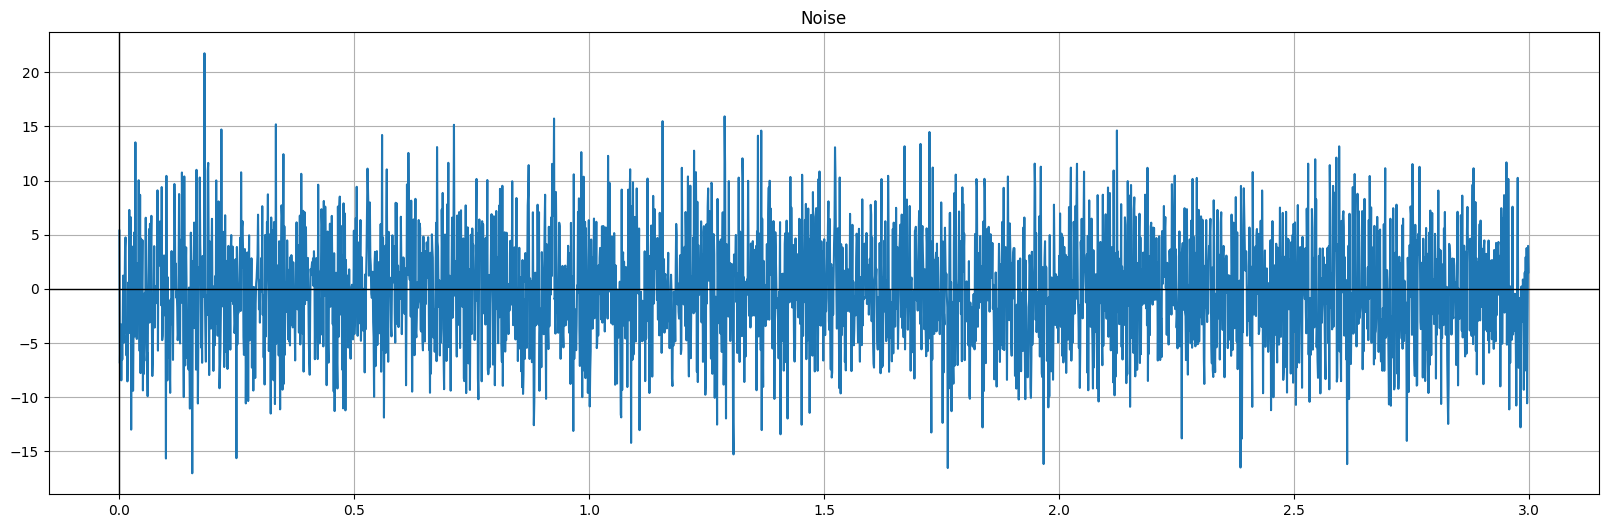

In [5]:
# noise level, measured in standard deviations
noiseamp = 5
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

plt.figure(figsize=(20, 6))

plt.plot(time, ampl, '.', label="Amplitude", markersize=1)
plt.title("Signal")
plt.grid()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(time, noise)
plt.title("Noise")
# draw the x-axis at y=0
plt.grid()
plt.axhline(0, color="k", linestyle="-", linewidth=1)
plt.axvline(0, color="k", linestyle="-", linewidth=1)
plt.show()

### Implement the running mean filter

windowsize = 41.0 ms

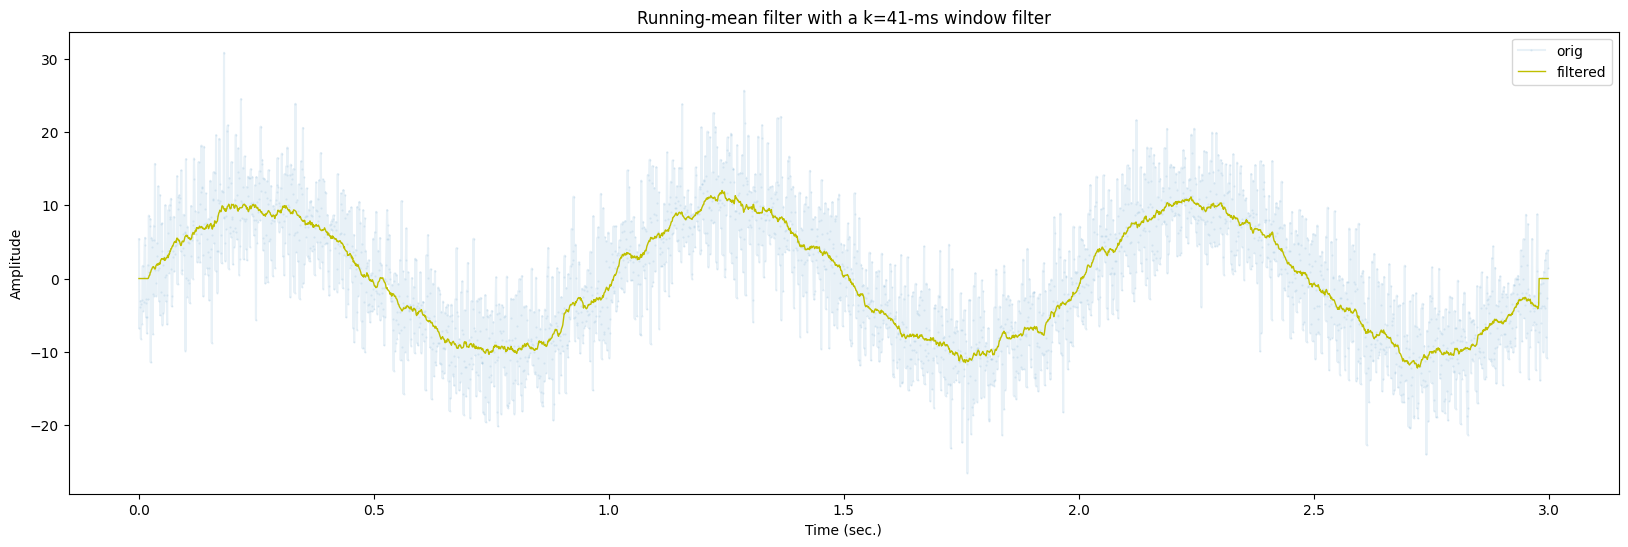

In [6]:
# initialize filtered signal vector
filtsig = np.zeros(n)  # 3000 zeros

# implement the running mean filter
k = 20  # filter window is actually k*2+1
for i in range(k, n - k):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i - k: i + k + 1])  # 2k+1 points

windowsize_sec = (k * 2 + 1) / srate  # [samples] / [samples/sec] = [sec]
windowsize = 1000 * windowsize_sec  # [ms/sec] * [samples] / [samples/sec] = [ms]

print(f"windowsize = {windowsize} ms")

plt.figure(figsize=(20, 6))
# plot the noisy and filtered signals
plt.plot(time, signal, '.-', label="orig", markersize=1, alpha=0.1)
plt.plot(time, filtsig, label="filtered", color="y", linewidth=1)

plt.legend()
plt.xlabel("Time (sec.)")
plt.ylabel("Amplitude")
plt.title("Running-mean filter with a k=%d-ms window filter" % windowsize)

plt.show()


---
# VIDEO: Gaussian-smooth a time series
---


### Create Signal

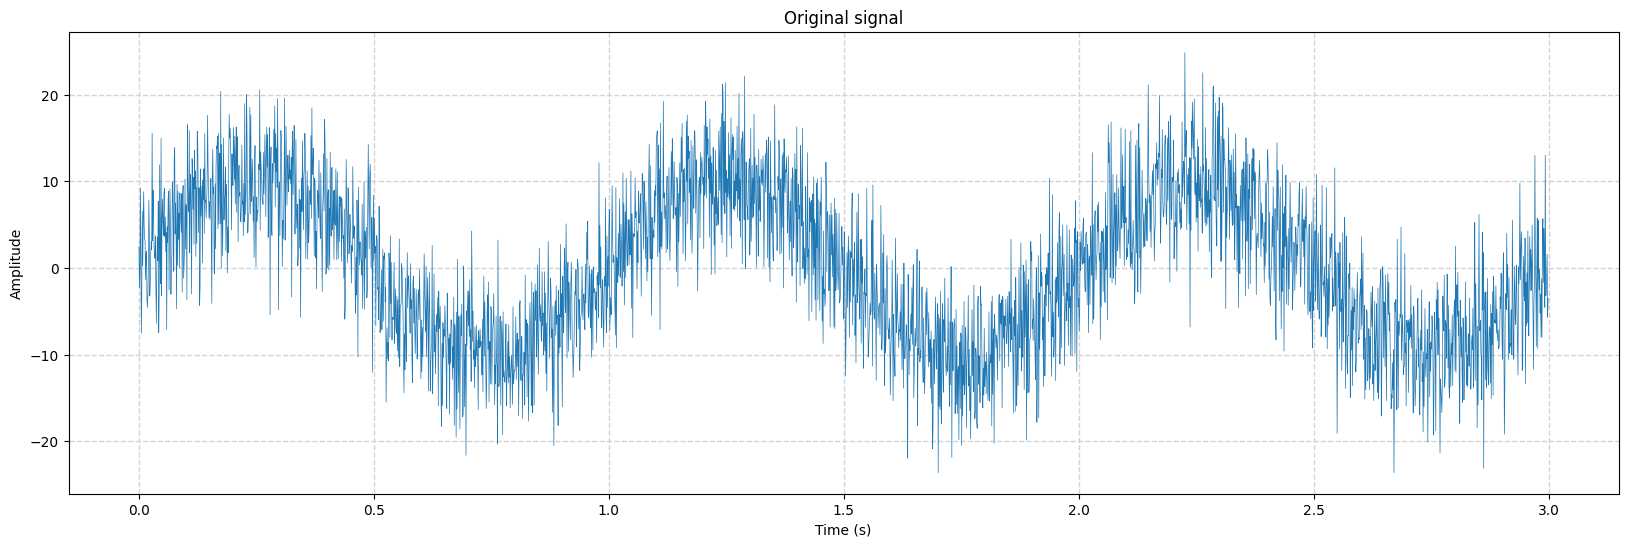

In [7]:
srate = 1000  # Hz
time = np.arange(0, 3, 1 / srate)
n = len(time)
p = 15  # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
# ampl = np.interp(np.linspace(1, p, n), np.arange(0, p), np.random.rand(p) * 30)
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

# plot the signal
plt.figure(figsize=(20, 6))
plt.plot(time, signal, '-', markersize=1, linewidth=.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original signal")
# a very light grid
plt.grid(color="#D3D3D3", linestyle="--", linewidth=1)
plt.show()

### Create Gaussian kernel

In [8]:
# full-width half-maximum: the key Gaussian parameter
fwhm = 25  # in ms

# normalized time vector in ms
k = 40
# in this case, the time value in ms is equal to the sample number (srate = 1000)
gtime = 1000 * np.arange(-k, k + 1) / srate  # 81 points: -40 to 40

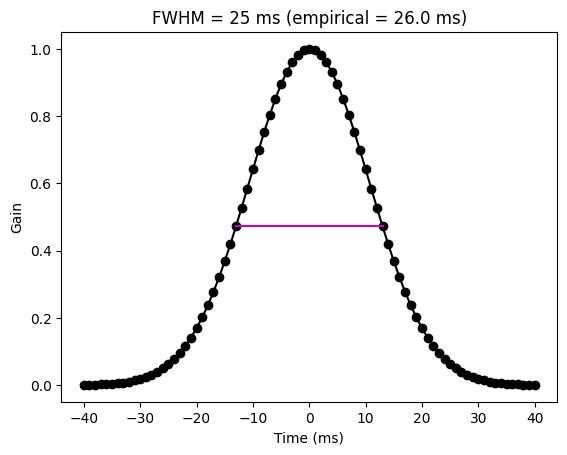

In [9]:
# Create Gaussian window
gauswin = np.exp(-(4 * np.log(2) * gtime ** 2) / fwhm ** 2)

# compute empirical FWHM (find the real FWHM) 
pstPeakHalf = k + np.argmin((gauswin[k:] - 0.5) ** 2)
prePeakHalf = np.argmin((gauswin - 0.5) ** 2)

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# show the Gaussian
plt.plot(gtime, gauswin, "ko-")
plt.plot(
    [gtime[prePeakHalf], gtime[pstPeakHalf]],
    [gauswin[prePeakHalf], gauswin[pstPeakHalf]],
    "m",
)
plt.title(
    f'FWHM = {fwhm} ms (empirical = {empFWHM} ms)')  # MAV: mean absolute value, computed as the sum of the absolute values of the signal divided by the number of samples 

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)
# title([ 'Gaussian kernel with requeted FWHM ' num2str(fwhm) ' ms (' num2str(empFWHM) ' ms achieved)' ])
plt.xlabel("Time (ms)")
plt.ylabel("Gain")

plt.show()

## implement the filter

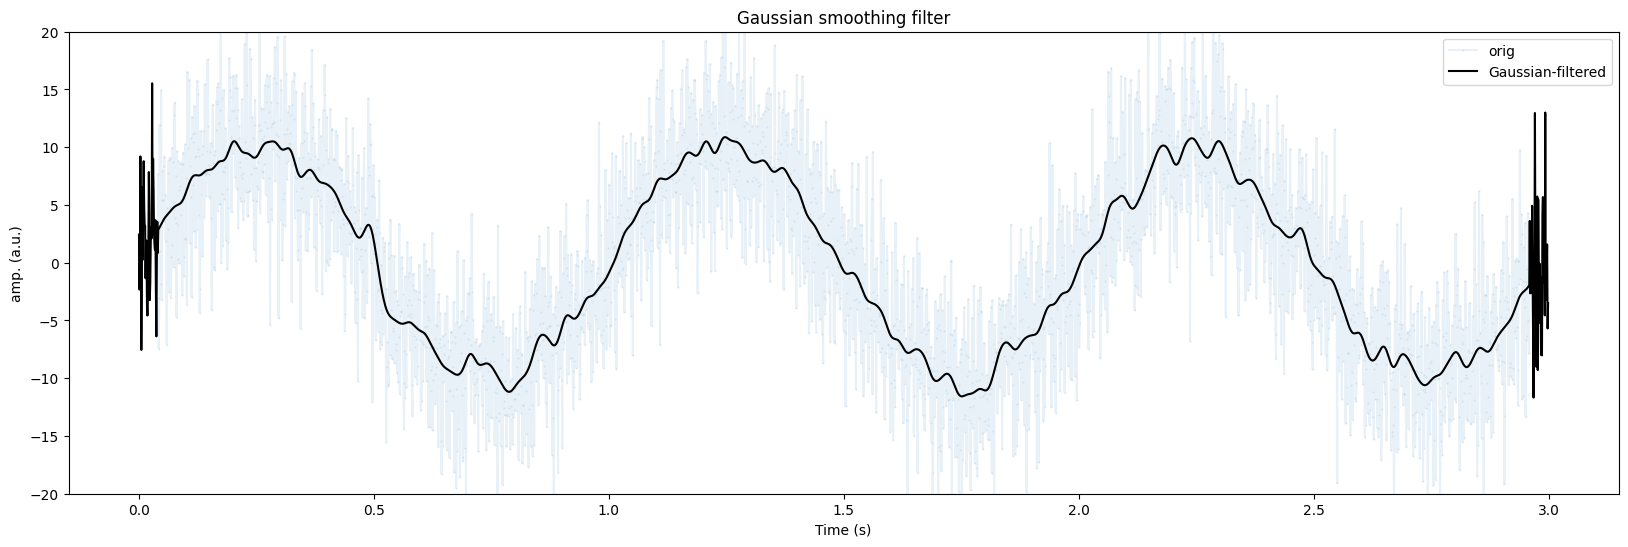

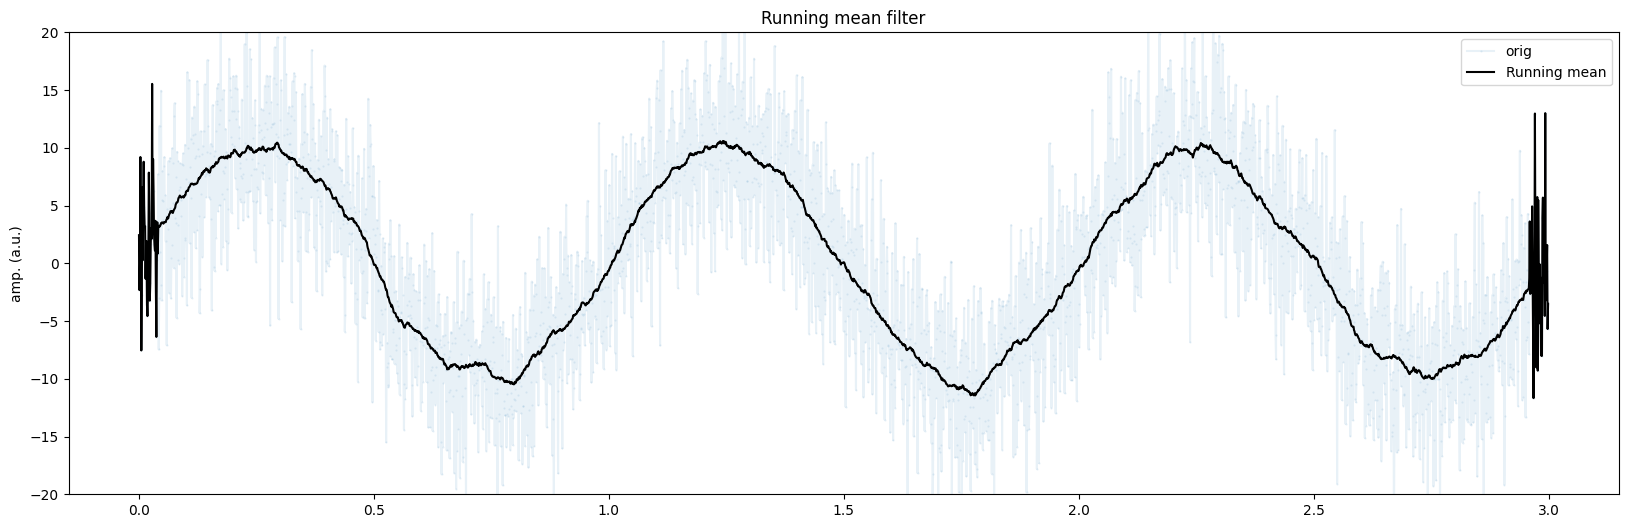

In [10]:
# initialize filtered signal vector
filtsigG = signal.copy()

# implement the running mean filter
for i in range(k + 1, n - k):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum(signal[i - k: i + k + 1] * gauswin)

# plot
YLIM = [-20, 20]

plt.figure(figsize=(20, 6))
# plt.plot(time, signal, "r", label="Original")
plt.plot(time, signal, '.-', label="orig", markersize=1, alpha=0.1)
plt.plot(time, filtsigG, "k", label="Gaussian-filtered")

plt.xlabel("Time (s)")
plt.ylabel("amp. (a.u.)")
plt.legend()
plt.title("Gaussian smoothing filter")
plt.ylim(YLIM)
plt.show()

## for comparison, plot mean smoothing filter

# initialize filtered signal vector
filtsigMean = signal.copy()

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 40  # filter window is actually mk*2+1
for i in range(mk + 1, n - mk - 1):
    # each point is the average of k surrounding points
    filtsigMean[i] = np.mean(signal[i - mk: i + mk + 1])

plt.figure(figsize=(20, 6))
# plt.plot(time, signal, "r", label="Original")
plt.plot(time, signal, '.-', label="orig", markersize=1, alpha=0.1)
plt.plot(time, filtsigMean, "k", label="Running mean")

plt.ylabel("amp. (a.u.)")
plt.title("Running mean filter")
plt.legend()
plt.ylim(YLIM)
plt.show()

# Zoom

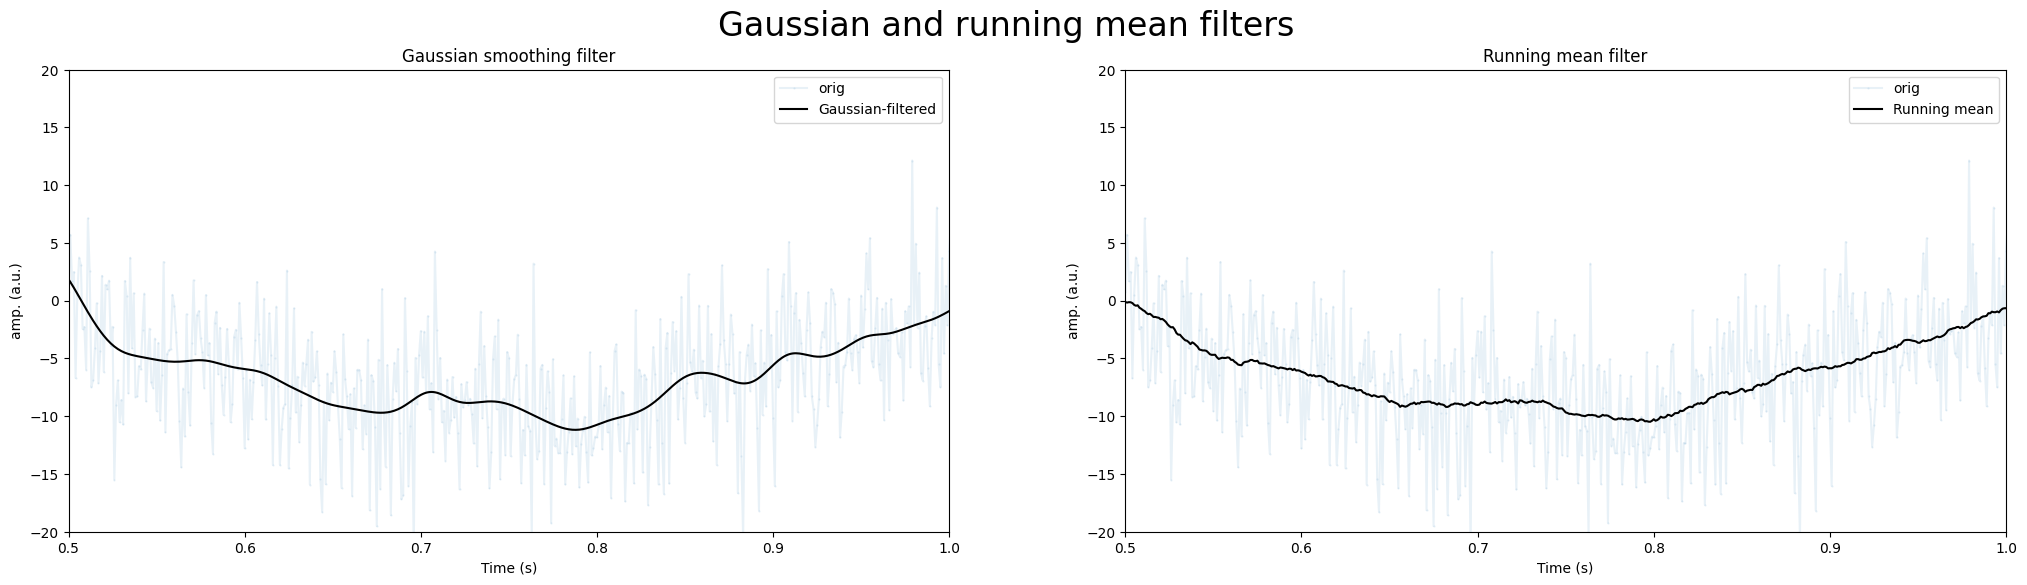

In [11]:
## plot the two filters together from 0.5 to 1.0 seconds
plt.figure(figsize=(25, 6))

plt.suptitle("Gaussian and running mean filters", fontsize=24)

plt.subplot(121)
plt.plot(time, signal, '.-', label="orig", markersize=1, alpha=0.1)
plt.plot(time, filtsigG, "k", label="Gaussian-filtered")
plt.title("Gaussian smoothing filter")
plt.xlabel("Time (s)")
plt.ylabel("amp. (a.u.)")
plt.legend()
plt.ylim(YLIM)
plt.xlim([0.5, 1.0])

plt.subplot(122)
plt.plot(time, signal, '.-', label="orig", markersize=1, alpha=0.1)
plt.plot(time, filtsigMean, "k", label="Running mean")
plt.title("Running mean filter")
plt.xlabel("Time (s)")
plt.ylabel("amp. (a.u.)")
plt.legend()
plt.ylim(YLIM)
plt.xlim([0.5, 1.0])

plt.show()

# FFT

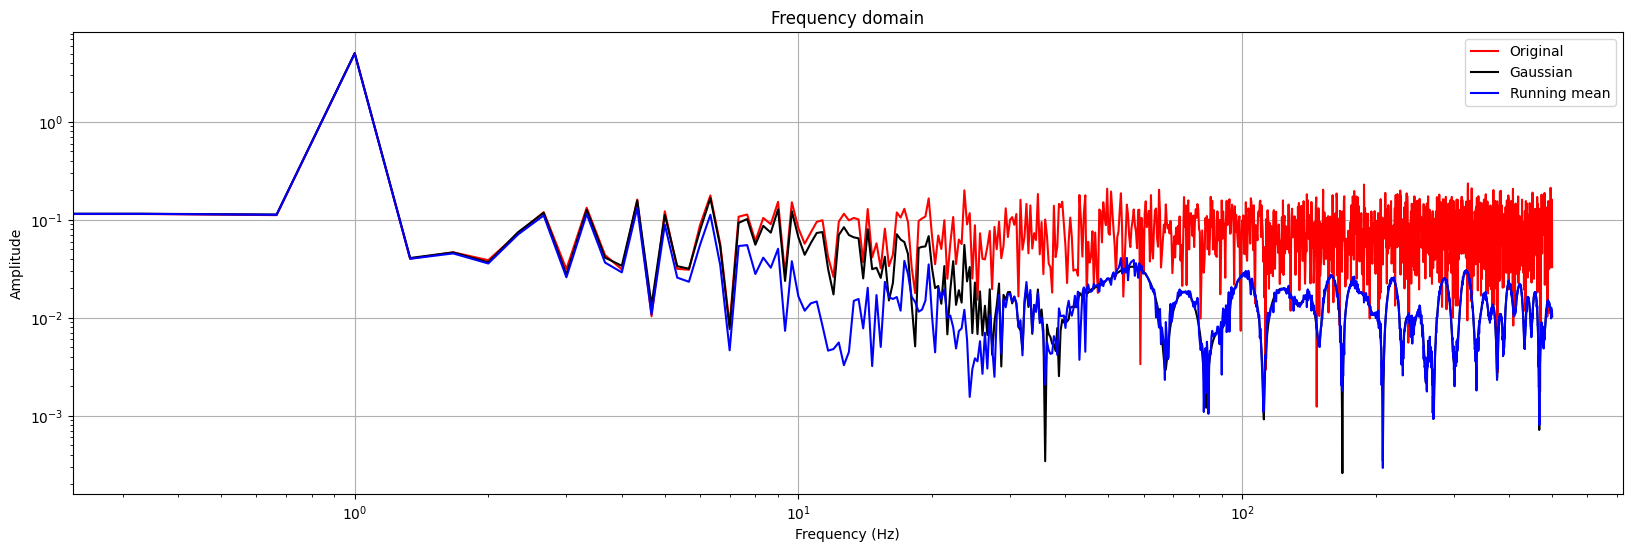

In [12]:
# make an FFT of the original and filtered signals

# frequencies
hz = np.linspace(0, srate / 2, int(np.floor(n / 2) + 1))

# FFT of original signal
signalX = np.fft.fft(signal) / n
signalX = signalX[0: len(hz)]

# FFT of Gaussian-filtered signal
filtsigGX = np.fft.fft(filtsigG) / n
filtsigGX = filtsigGX[0: len(hz)]

# FFT of running-mean-filtered signal
filtsigMeanX = np.fft.fft(filtsigMean) / n
filtsigMeanX = filtsigMeanX[0: len(hz)]

# plot using loglog
plt.figure(figsize=(20, 6))
# use loglog scale
plt.loglog(hz, np.abs(signalX), "r", label="Original")
plt.loglog(hz, np.abs(filtsigGX), "k", label="Gaussian")
plt.loglog(hz, np.abs(filtsigMeanX), "b", label="Running mean")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency domain")
plt.legend()
plt.grid()
plt.show()


---
# VIDEO: Gaussian-smooth a spike time series
---


(-10.0, 10.0)

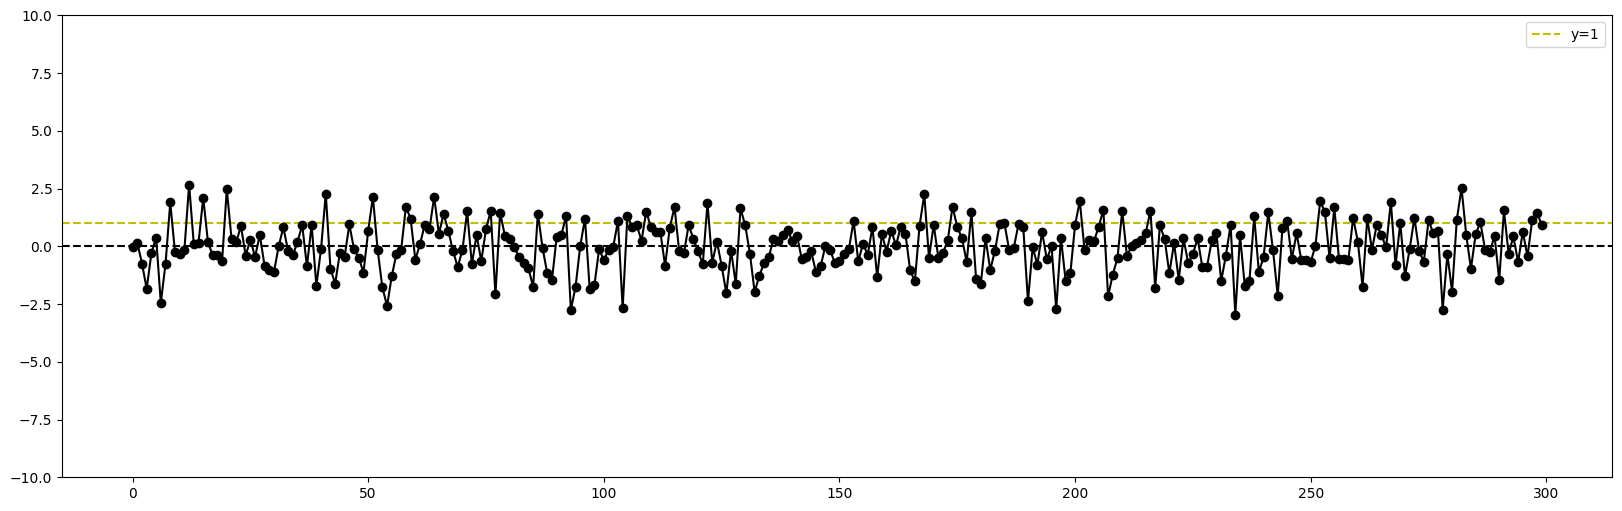

In [13]:
## generate time series of random spikes

# number of spikes
n = 300

random_nums = np.random.randn(n)

# plot the random numbers
plt.figure(figsize=(20, 6))
plt.axhline(0, color="k", linestyle="--")
plt.axhline(1, color="y", linestyle="--", label="y=1")
plt.legend()
plt.plot(random_nums, "ko-")
plt.ylim([-10, 10])

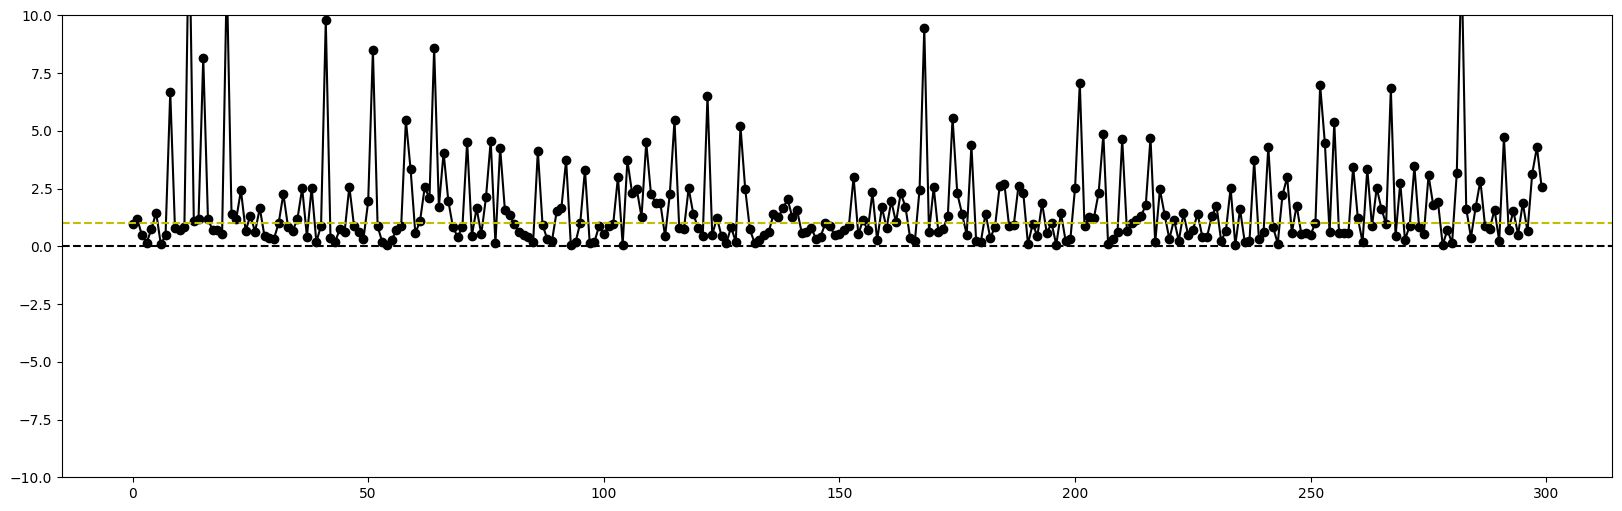

In [14]:
# exponential of random numbers
random_exp = np.exp(random_nums)
# inter-spike intervals (exponential distribution for bursts)
isi = np.round(random_exp * 10)

plt.figure(figsize=(20, 6))
plt.axhline(0, color="k", linestyle="--")
plt.plot(random_exp, "ko-")
plt.axhline(1, color="y", linestyle="--")
plt.ylim([-10, 10])
plt.show()


Al tomar la exponencial de la señal de ruido, todos los valores son ahora positivos. Además, la distribución exponencial significa que la mayoría de los valores son cercanos a cero, pero algunos valores son mucho más grandes. Esto es lo que se espera de una señal de ruido de tipo "ráfaga" (es decir, una señal que tiene ráfagas de actividad, seguidas de períodos de silencio). 

Para convertir estos valores en intervalos de tiempo entre ráfagas, simplemente multiplicamos por un factor de escala (en este caso, 10). Esto convierte los valores en intervalos de tiempo en milisegundos.

El tiempo en el que ocurrirán los spikes es la suma acumulada de los intervalos de tiempo entre ráfagas. Como la mayoría de los intervalos de tiempo son pequeños, la suma acumulada aumentará lentamente, agrupando los spikes en el tiempo. 

Sin embargo, cuando se encuentre con un intervalo de tiempo grande, la suma acumulada aumentará rápidamente, creando un nuevo grupo de spikes separado en el tiempo del grupo anterior. Cada grupo de spikes se llama "ráfaga".

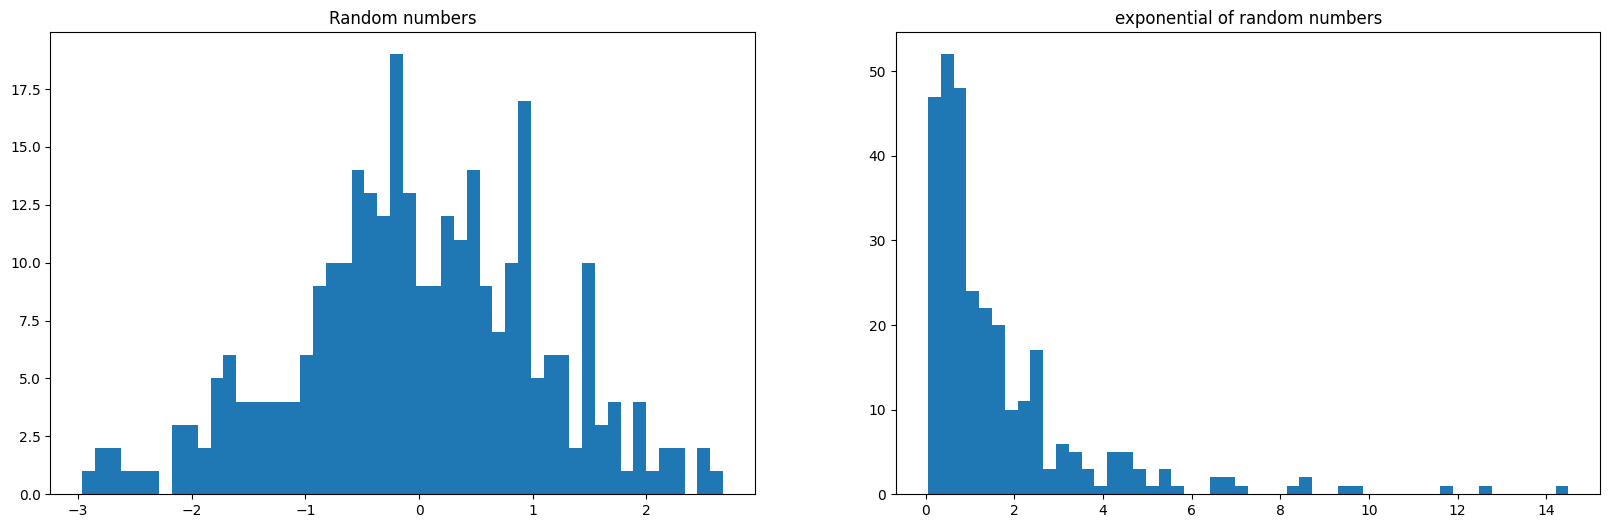

In [15]:
# histograms of the random numbers and the inter-spike intervals
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.hist(random_nums, 50)
plt.title("Random numbers")

plt.subplot(122)
plt.hist(random_exp, 50)
plt.title("exponential of random numbers")
plt.show()

En el histograma exponencial, se observa que la mayoría de los valores están cerca de cero, pero algunos valores son mucho más grandes. Como estos valores representan intervalos de tiempo entre ráfagas, esto significa que la mayoría de los pulsos estarán agrupados entre sí, pero ocasionalmente habrá un intervalo de tiempo largo que separará dos grupos de pulsos. Estos grupos constituyen las ráfagas de actividad.

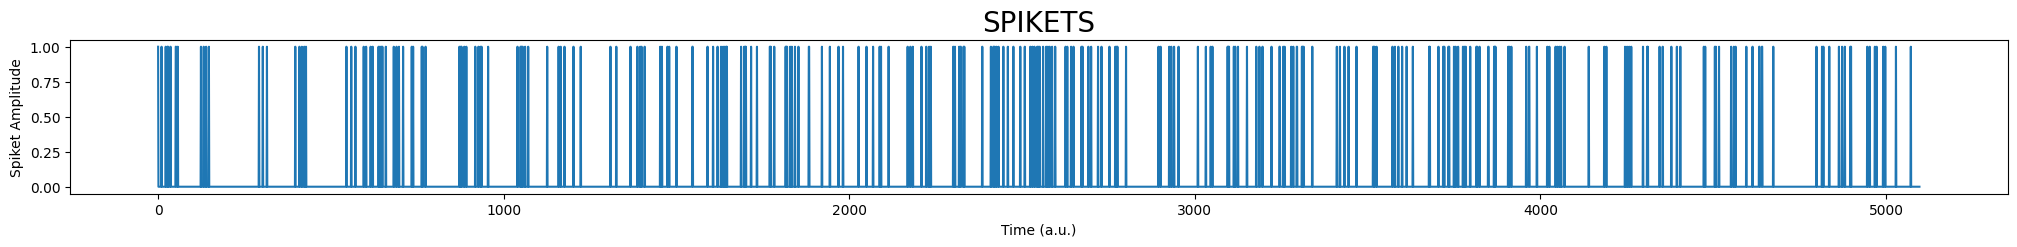

In [16]:
# generate spike time series
spikets = np.zeros(int(sum(isi)))  # the number of spikes will be the sum of the inter-spike intervals

for i in range(0, n):  # n = 300
    spicket_index = int(np.sum(isi[0:i]))
    spikets[spicket_index] = 1

# plot
plt.figure(figsize=(25, 2))
plt.plot(spikets)
plt.xlabel("Time (a.u.)")  # a.u. stands for arbitrary units
plt.ylabel("Spiket Amplitude")
plt.title("SPIKETS", fontsize=20)
plt.show()

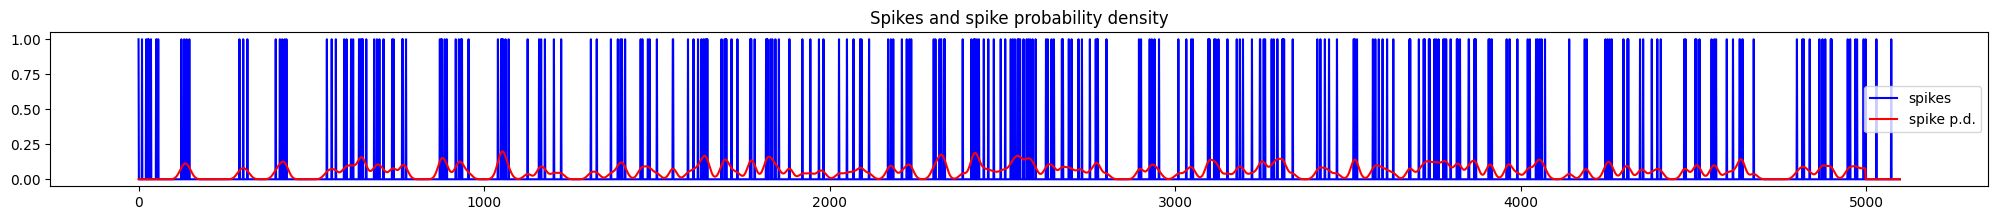

In [17]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 25  # in points

# normalized time vector in points
k = 100
gtime = np.arange(-k, k + 1)

# create Gaussian window
gauswin = np.exp(-(4 * np.log(2) * gtime ** 2) / fwhm ** 2)
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the weighted running mean filter
for i in range(k + 1, len(spikets) - k):
    filtsigG[i] = np.sum(spikets[i - k: i + k + 1] * gauswin)

# plot the filtered signal (spike probability density)
plt.figure(figsize=(25, 2))
plt.plot(spikets, "b", label="spikes")
plt.plot(filtsigG, "r", label="spike p.d.")
plt.legend()
plt.title("Spikes and spike probability density")
plt.show()

How to make a plot interactive in Jupyter Notebook? (inside PyCharm) 
To make a plot interactive in Jupyter Notebook, you can use the `%matplotlib notebook` magic command. This command will allow you to interact with the plot, zoom in, and pan around the plot.
This command should be placed at the beginning of the cell where you want to create the interactive plot.


---
# VIDEO: Denoising via TKEO
---


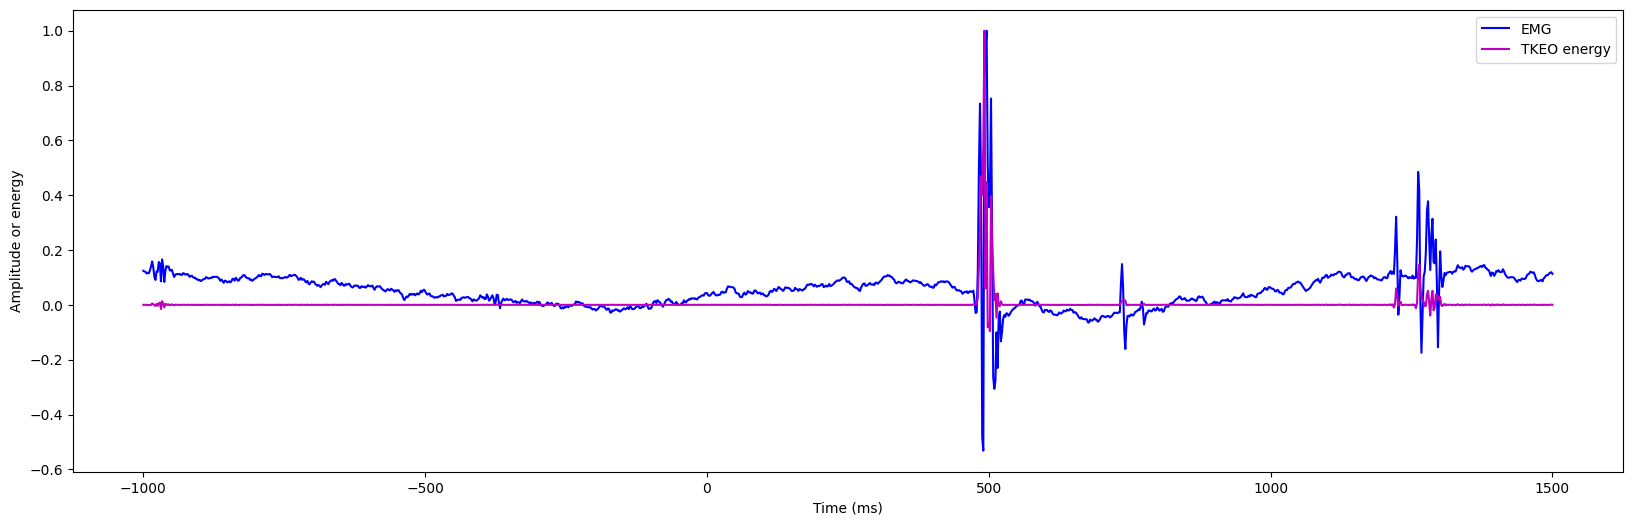

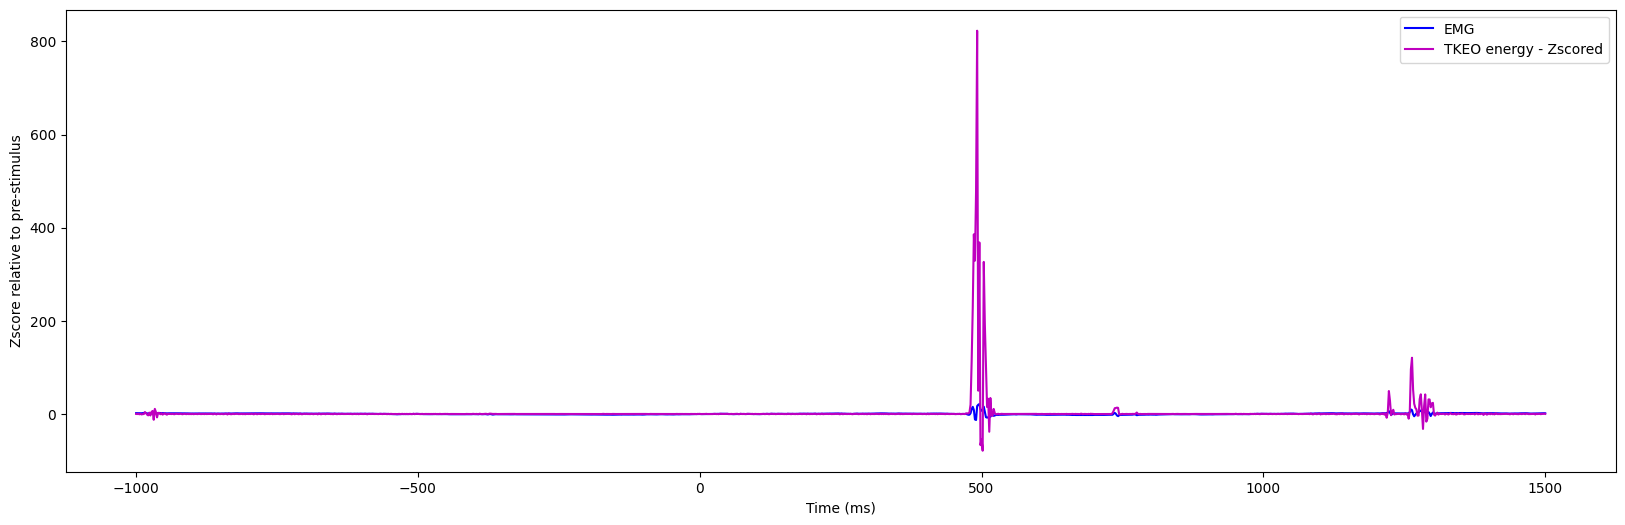

In [18]:
# import data
emgdata = sio.loadmat("emg4TKEO.mat")

# extract needed variables
emgtime = emgdata["emgtime"][0]
emg = emgdata["emg"][0]

# initialize filtered signal
emgf = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1, len(emgf) - 1):
    emgf[i] = emg[i] ** 2 - emg[i - 1] * emg[i + 1]

# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[1:-1] ** 2 - emg[0:-2] * emg[2:]

## convert both signals to zscore

# find timepoint zero
time0 = np.argmin(emgtime ** 2)

# convert original EMG to z-score from time-zero
emgZ = (emg - np.mean(emg[0:time0])) / np.std(emg[0:time0])

# same for filtered EMG energy
emgZf = (emgf - np.mean(emgf[0:time0])) / np.std(emgf[0:time0])

## plot
# plot "raw" (normalized to max.1)
plt.figure(figsize=(20, 6))
plt.plot(emgtime, emg / np.max(emg), "b", label="EMG")
plt.plot(emgtime, emgf / np.max(emgf), "m", label="TKEO energy")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude or energy")
plt.legend()

plt.show()

# plot zscored
plt.figure(figsize=(20, 6))
plt.plot(emgtime, emgZ, "b", label="EMG")
plt.plot(emgtime, emgZf, "m", label="TKEO energy - Zscored")

plt.xlabel("Time (ms)")
plt.ylabel("Zscore relative to pre-stimulus")
plt.legend()
plt.show()


---
VIDEO: Median filter to remove spike noise
---


### Create Signal

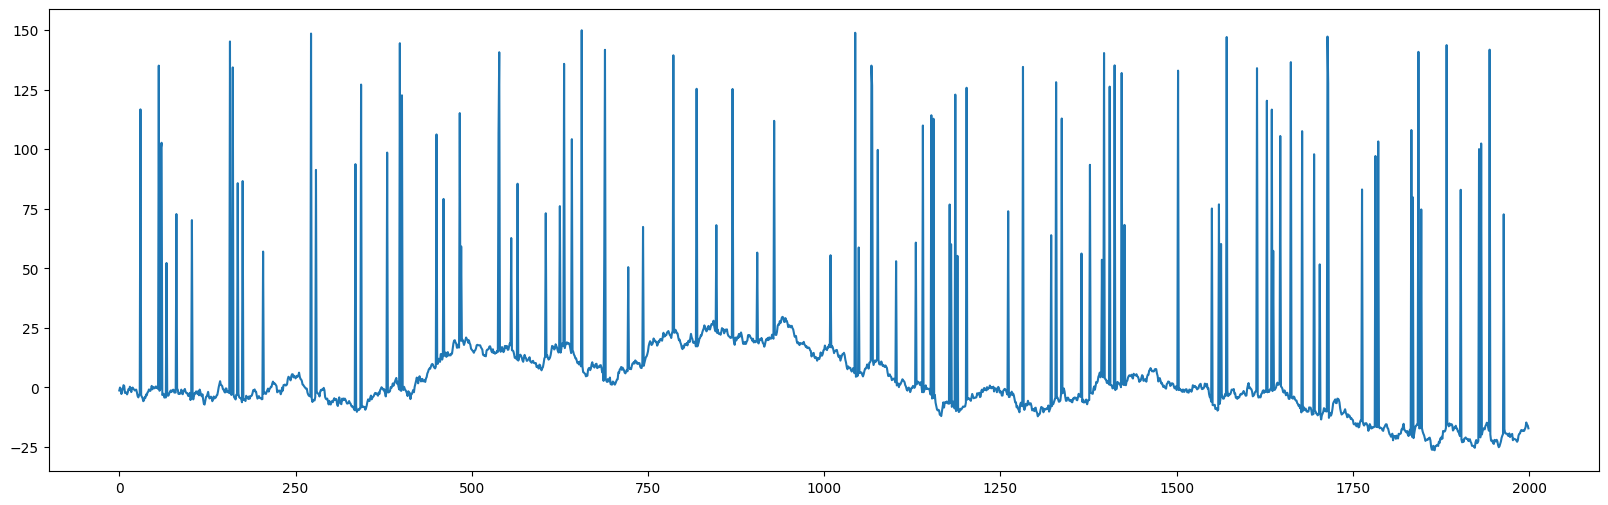

In [36]:
# create signal
n = 2000
signal = np.cumsum(np.random.randn(n))

# proportion of time points to replace with noise
propnoise = 0.05

# find noise points
noisepnts = np.random.permutation(n)
noisepnts = noisepnts[0: int(n * propnoise)]

# generate signal and replace points with noise
signal[noisepnts] = 50 + np.random.rand(len(noisepnts)) * 100

# plot the signal
plt.figure(figsize=(20, 6))
plt.plot(range(0, n), signal)
plt.show()

### Implement the median filter

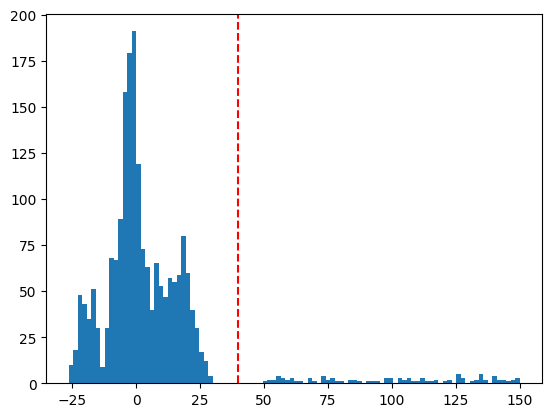

In [38]:
# use hist to pick threshold
plt.hist(signal, 100)
plt.axvline(40, color="r", linestyle="--")
plt.show()

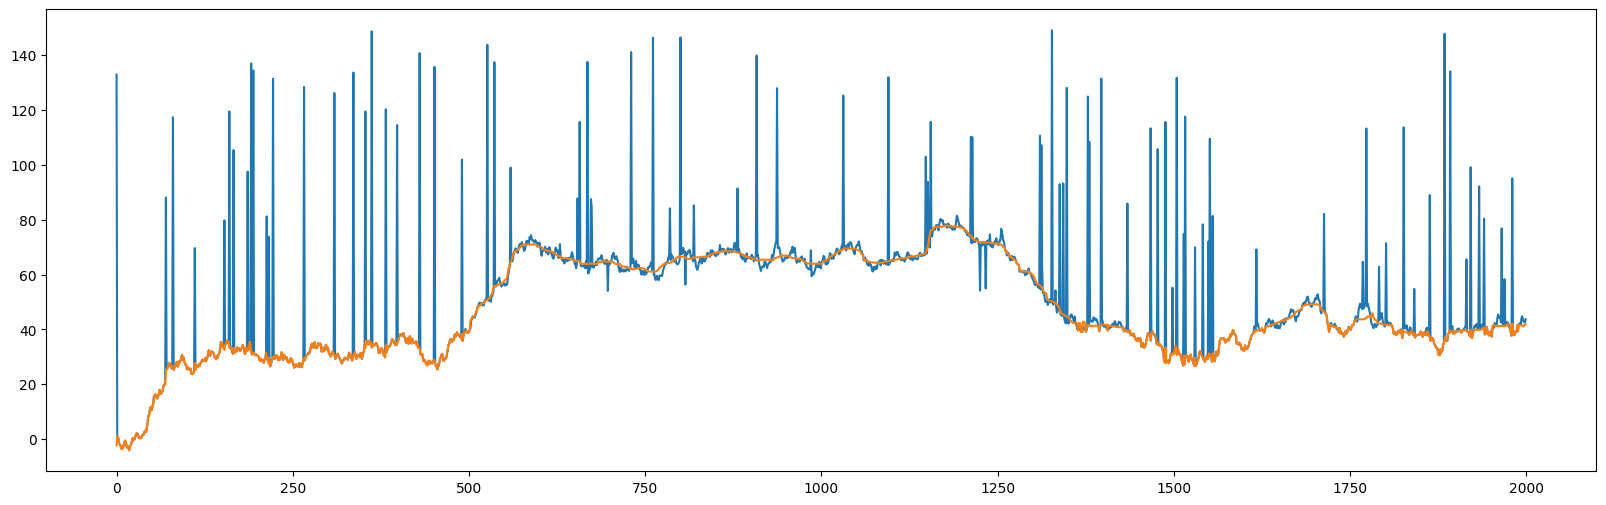

In [21]:
# visual-picked threshold
threshold = 40

# find data values above the threshold
suprathresh = np.where(signal > threshold)[0]

# initialize filtered signal
filtsig = copy.deepcopy(signal)

# loop through suprathreshold points and set to median of k
k = 20  # actual window is k*2+1
for ti in range(len(suprathresh)):
    # lower and upper bounds
    lowbnd = np.max((0, suprathresh[ti] - k))
    uppbnd = np.min((suprathresh[ti] + k + 1, n))

    # compute median of surrounding points
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])

# plot
plt.figure(figsize=(20, 6))
plt.plot(range(0, n), signal, range(0, n), filtsig)
plt.show()


---
# VIDEO: Remove linear trend
---


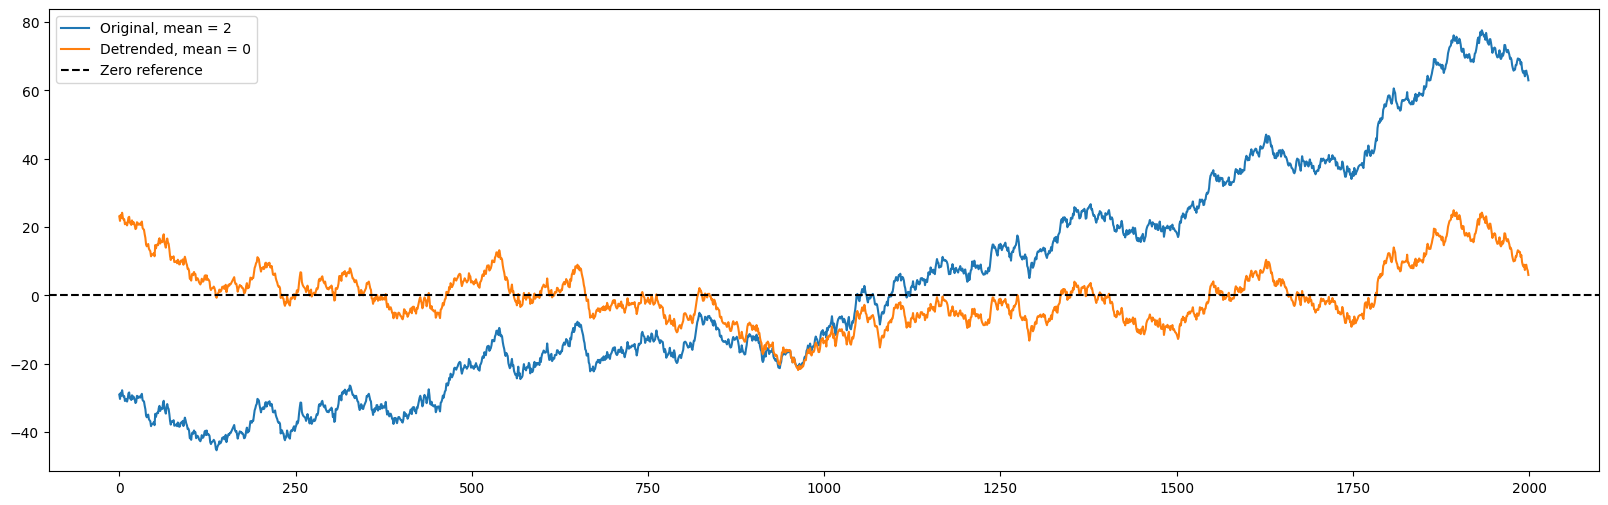

In [22]:
from scipy.signal import detrend
# create signal with linear trend imposed (imposed trend = linspace(-30,30, n))
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30, 30, n)

# linear detrending. The detrend function removes the best linear fit from the signal
detsignal = detrend(signal)

# get means
omean = np.mean(signal)  # original mean
dmean = np.mean(detsignal)  # detrended mean

# plot signal and detrended signal
plt.figure(figsize=(20, 6))
plt.plot(range(0, n), signal, label="Original, mean = %d" % omean)
plt.plot(range(0, n), detsignal, label="Detrended, mean = %d" % dmean)
plt.axhline(0, color="k", linestyle="--", label="Zero reference")

plt.legend()
plt.show()


---
# VIDEO: Remove nonlinear trend with polynomials
---


In [23]:
print(np.random.randn(1))

[0.26084919]

a = [0. 0. 0. 0. 0.]

a = [-0.48373737  1.61918016 -0.43605404 -2.32751352 -0.84306382]

The polynomial is: -0.48x^0 +1.62x^1 -0.44x^2 -2.33x^3 -0.84x^4

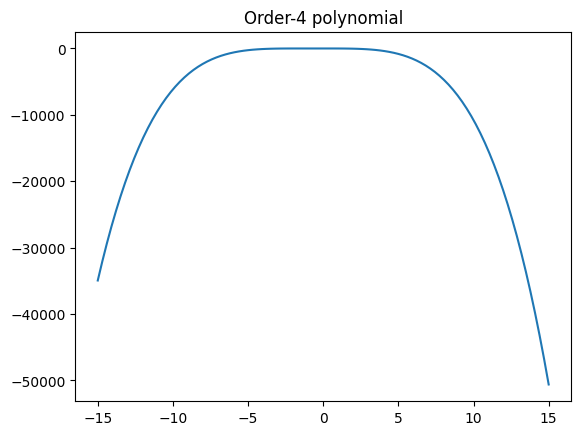

In [24]:
## polynomial intuition

order = 4
x = np.linspace(-15, 15, 100)

y = np.zeros(len(x))
a = np.zeros(order + 1)
print(f'a = {a}')

for i in range(order + 1):
    a[i] = np.random.randn()
    y = y + a[i] * x ** i

plt.plot(x, y)
plt.title("Order-%d polynomial" % order)
print(f'a = {a}')

poly_str = "The polynomial is: "
for i in range(order + 1):
    poly_str += ("+" if a[i] > 0 else "") + f"{a[i]:.2f}x^{i} "
print(poly_str)
    
plt.show()

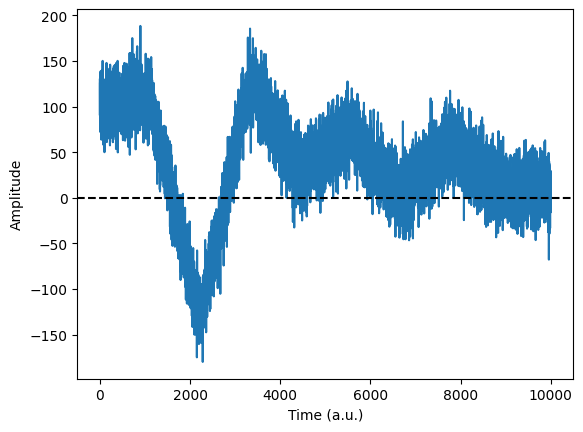

In [25]:
## generate signal with slow polynomial artifact

n = 10000
t = range(n)
k = 10  # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(1, k, n), np.arange(0, k), 100 * np.random.randn(k))
signal = slowdrift + 20 * np.random.randn(n)

# plot
plt.plot(t, signal)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Time (a.u.)")
plt.ylabel("Amplitude")
plt.show()

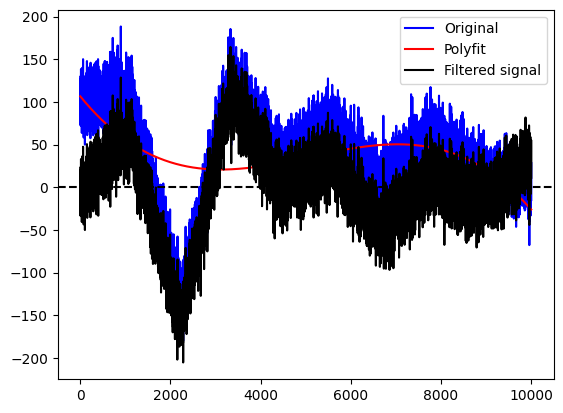

In [26]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
p = np.polyfit(t, signal, 3)

# predicted data is evaluation of polynomial
yHat = np.polyval(p, t)

# compute residual (the cleaned signal)
residual = signal - yHat

# now plot the fit (the function that will be removed)
plt.plot(t, signal, "b", label="Original")
plt.plot(t, yHat, "r", label="Polyfit")
plt.plot(t, residual, "k", label="Filtered signal")
plt.axhline(0, color="k", linestyle="--")
plt.legend()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\856301335.py:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\856301335.py:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\856301335.py:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\856301335.py:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\856301335.py:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\856301335.py:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(

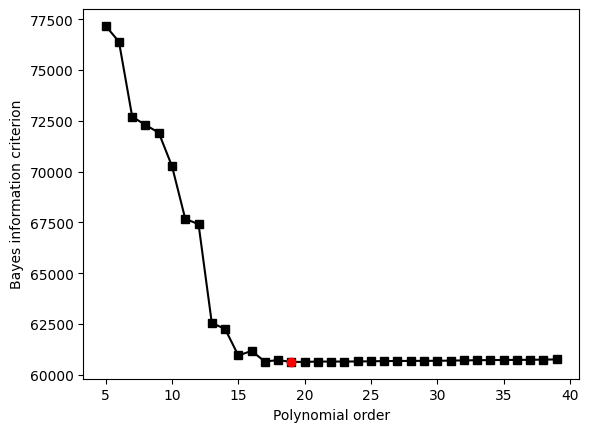

In [27]:
## Bayes information criterion to find optimal order

# possible orders
orders = range(5, 40)

# sum of squared errors (sse is reserved!)
sse1 = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):
    # compute polynomial (fitting time series)
    yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)

    # compute fit of model to data (sum of squared errors)
    sse1[ri] = np.sum((yHat - signal) ** 2) / n

# Bayes information criterion
bic = n * np.log(sse1) + orders * np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
plt.plot(orders, bic, "ks-")
plt.plot(orders[idx], bestP, "ro")
plt.xlabel("Polynomial order")
plt.ylabel("Bayes information criterion")
plt.show()

# IGNORE WARNINGS!!!

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9904\413746795.py:4: RankWarning: Polyfit may be poorly conditioned
  polycoefs = np.polyfit(t, signal, orders[idx])


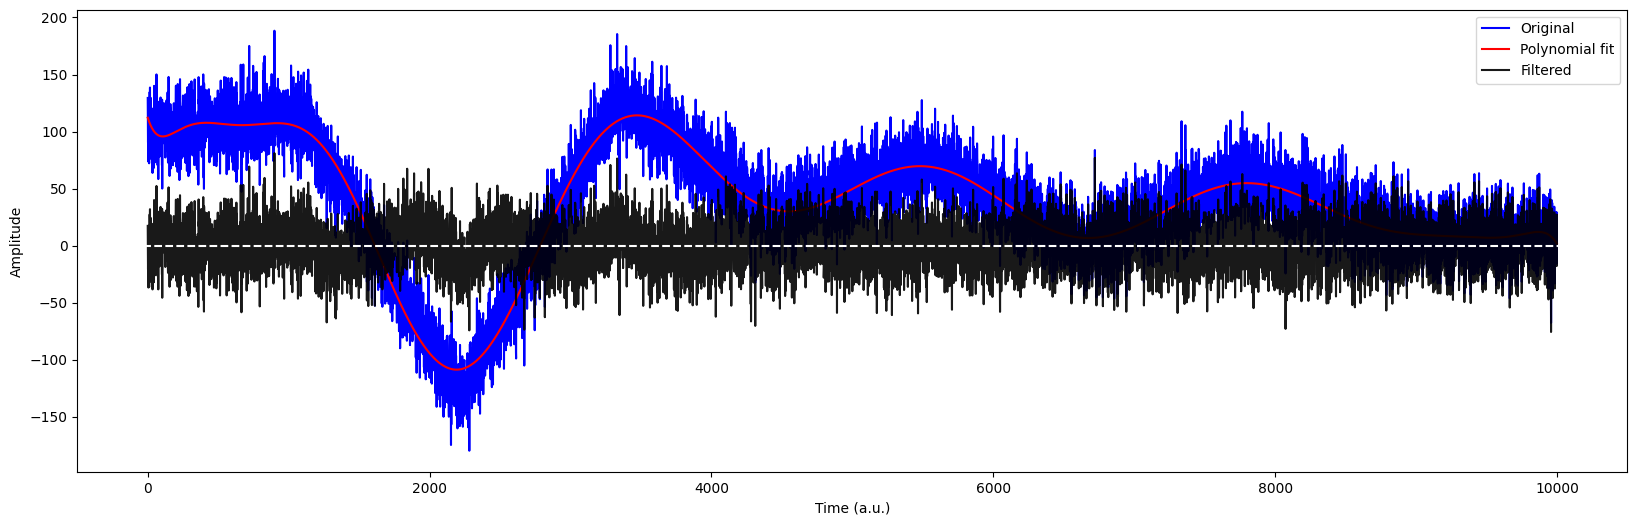

In [28]:
## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = np.polyfit(t, signal, orders[idx])

# estimated data based on the coefficients
yHat = np.polyval(polycoefs, t)

# filtered signal is residual
filtsig = signal - yHat

## plotting
plt.figure(figsize=(20, 6))

plt.plot(t, signal, "b", label="Original")
plt.plot(t, yHat, "r", label="Polynomial fit")
plt.plot(t, filtsig, "k", label="Filtered", alpha=0.9)
plt.axhline(0, color="w", linestyle="--")

plt.xlabel("Time (a.u.)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# IGNORE WARNINGS!!!


---
# VIDEO: Averaging multiple repetitions (time-synchronous averaging)
---


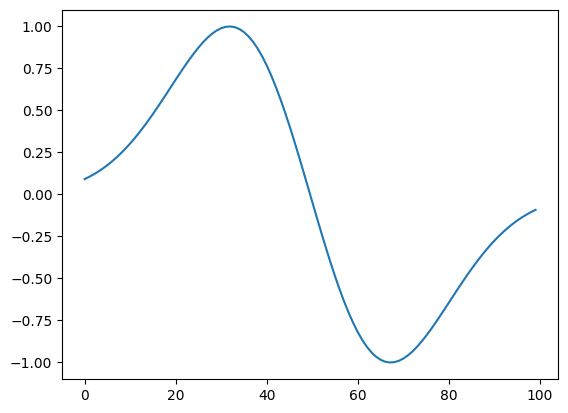

In [29]:
## simulate data

# create event (derivative of Gaussian)
k = 100  # duration of event in time points
event = np.diff(np.exp(-np.linspace(-2, 2, k + 1) ** 2))
event = event / np.max(event)  # normalize to max=1

plot(event); show()

In [30]:
# event onset times
Nevents = 30
onsettimes = np.random.permutation(10000 - k)  # this function returns a random permutation of the numbers from 0 to 10000-k
print(f"onsettimes = {onsettimes}")
onsettimes = onsettimes[0:Nevents]  # take the first Nevents (30) onset times
print(f"onsettimes = {onsettimes}")

onsettimes = [5207 6454  464 ... 5271  680 9107]

onsettimes = [5207 6454  464 9067 3952 6930 7139 9608 7516  416 2733 1613 3294 6720
 4570 2819 7581 9291 9543 7371 7508 6067 3354 6630 2548  871 1886 6038
 6834 7591]

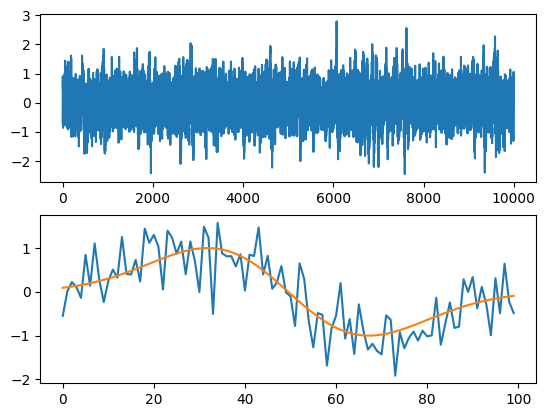

In [31]:
# put event into data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]: onsettimes[ei] + k] = event

# add noise
data = data + 0.5 * np.random.randn(len(data))

# plot data
plt.subplot(211)
plt.plot(data)

# plot one event
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]: onsettimes[3] + k])
plt.plot(range(k), event)
plt.show()

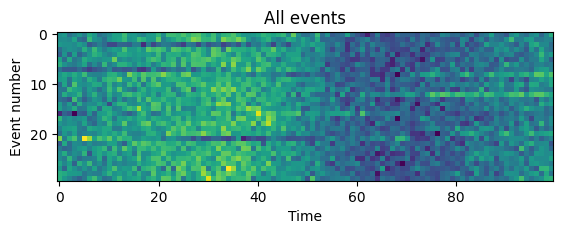

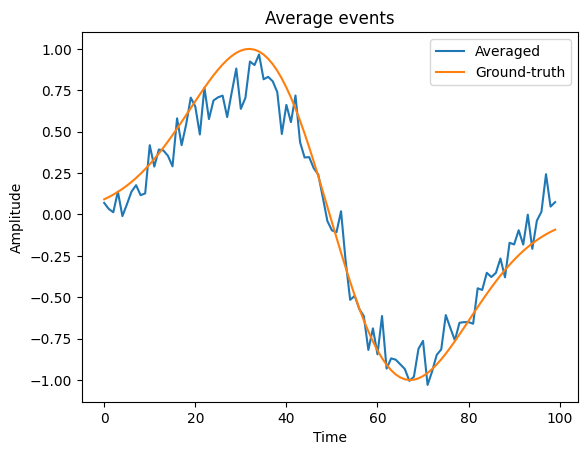

In [32]:
## extract all events into a matrix

datamatrix = np.zeros((Nevents, k))

for ei in range(Nevents):
    datamatrix[ei, :] = data[onsettimes[ei]: onsettimes[ei] + k]

plt.imshow(datamatrix)
plt.xlabel("Time")
plt.ylabel("Event number")
plt.title("All events")
plt.show()

plt.plot(range(0, k), np.mean(datamatrix, axis=0), label="Averaged")
plt.plot(range(0, k), event, label="Ground-truth")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Average events")
plt.show()


---
# VIDEO: Remove artifact via least-squares template-matching
---


In [33]:
# load dataset
matdat = sio.loadmat("templateProjection.mat")
EEGdat = matdat["EEGdat"]
eyedat = matdat["eyedat"]
timevec = matdat["timevec"][0]
MN = np.shape(EEGdat)  # matrix sizes

# initialize residual data
resdat = np.zeros(np.shape(EEGdat))

# loop over trials
for triali in range(MN[1]):
    # build the least-squares model as intercept and EOG from this trial
    X = np.column_stack((np.ones(MN[0]), eyedat[:, triali]))

    # compute regression coefficients for EEG channel
    b = np.linalg.solve(X.T @ X, X.T @ EEGdat[:, triali])

    # predicted data
    yHat = X @ b

    # new data are the residuals after projecting out the best EKG fit
    resdat[:, triali] = EEGdat[:, triali] - yHat

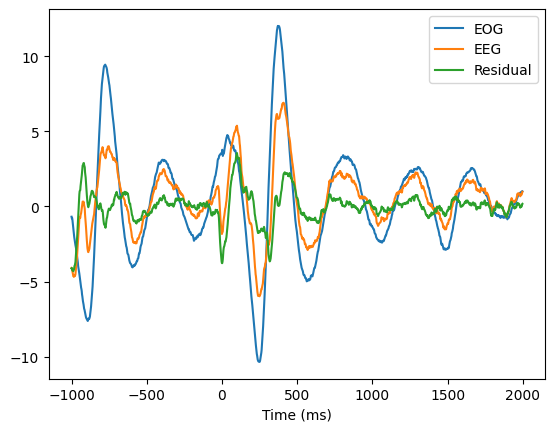

In [34]:
### plotting

# trial averages
plt.plot(timevec, np.mean(eyedat, axis=1), label="EOG")
plt.plot(timevec, np.mean(EEGdat, axis=1), label="EEG")
plt.plot(timevec, np.mean(resdat, 1), label="Residual")

plt.xlabel("Time (ms)")
plt.legend()
plt.show()

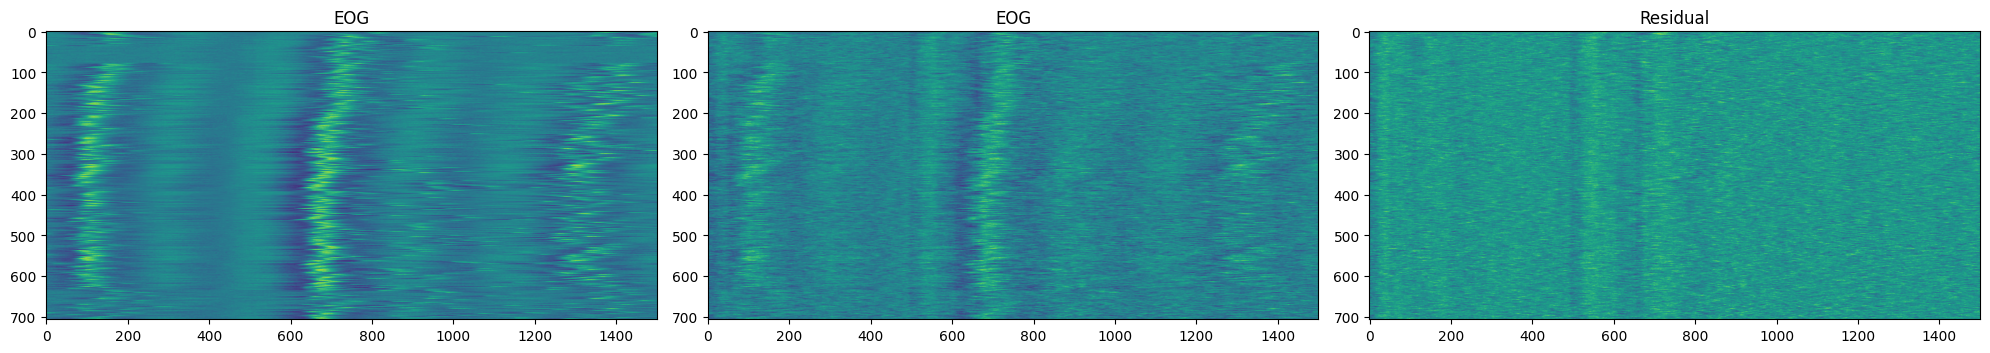

In [35]:
# show all trials in a map
clim = [-1, 1] * 20

plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.imshow(eyedat.T)
plt.title("EOG")

plt.subplot(132)
plt.imshow(EEGdat.T)
plt.title("EOG")

plt.subplot(133)
plt.imshow(resdat.T)
plt.title("Residual")

plt.tight_layout()
plt.show()